In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import nbimporter
from diametre_monnaie import conversion_piece

In [2]:
image_path = '../DataBase/image7.jpg' 

reference_object_mm = 22.6  # diamètre de la pièce de monnaie en mm 

# Les dimensions réelles en millimètres de la piece 

diametre_reel_mm = 20  # Diamètre réel du filetage en mm  
pas_reel_mm = 25.4 / 14 # Pas réel du filetage en mm

In [3]:
def match(template,img):
    w, h = template.shape[::-1]
    res = cv2.matchTemplate(img,template,cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(img,top_left, bottom_right, 255, 2)
    
    return img,res,max_val

In [4]:
def extract_line_pixels(img, start_point, end_point):
    height, width = img.shape[:2]  # Obtenir les dimensions de l'image
    num_points = max(abs(end_point[1] - start_point[1]), abs(end_point[0] - start_point[0]))
    
    x_values = np.linspace(start_point[0], end_point[0], num=num_points, endpoint=False).astype(int)
    y_values = np.linspace(start_point[1], end_point[1], num=num_points, endpoint=False).astype(int)
    
    x_values = np.clip(x_values, 0, width-1)
    y_values = np.clip(y_values, 0, height-1)
    
    pixel_values = img[y_values, x_values]
    
    return pixel_values

In [5]:
def draw_tooth_pattern(image_path, pas_reel_mm, reference_object_mm, rotation):
    # Supposons que cette fonction retourne la taille en pixels du diamètre réel
    size_pixels = conversion_piece(image_path, reference_object_mm)
    
    if size_pixels <= 0:
        raise ValueError("La taille en pixels doit être positive et non nulle")

    pas_pixels = pas_reel_mm / size_pixels
    tooth_height = max(int(1 / size_pixels), 1)  # Assurez-vous que la hauteur est au moins 1
    
    pattern_width = int(pas_pixels) * 4  # Largeur pour 4 dents
    
    pattern_image = np.zeros((tooth_height, pattern_width), dtype=np.uint8)
    
    # Dessiner 4 dents
    for i in range(4):
        start_x = int(i * pas_pixels + pas_pixels * 0.25)
        end_x = int((i + 1) * pas_pixels - pas_pixels * 0.25)
        middle_x = int((start_x + end_x) / 2)
        
        cv2.line(pattern_image, (start_x, tooth_height - 1), (middle_x, 0), 255, 1)
        cv2.line(pattern_image, (middle_x, 0), (end_x, tooth_height - 1), 255, 1)

    if rotation:
        pattern_image = cv2.rotate(pattern_image, cv2.ROTATE_180)

    return pattern_image


In [6]:
def match_and_draw_normal_and_analyze(image_path, pas_reel_mm, reference_object_mm, rotation):
    template = draw_tooth_pattern(image_path, pas_reel_mm, reference_object_mm, rotation)
    
    # Ensure the image is correctly loaded
    img_color = cv2.imread(image_path)
    if img_color is None:
        raise FileNotFoundError("The image could not be loaded. Please check the image path.")
    
    # Continue with filtering and processing as before
    img_filtered = cv2.bilateralFilter(img_color, d=9, sigmaColor=75, sigmaSpace=75)
    gray = cv2.cvtColor(img_filtered, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray_clahe = clahe.apply(gray)
    thresh = cv2.adaptiveThreshold(gray_clahe, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    thresh = cv2.bitwise_not(thresh)
    cv2.imwrite('try.jpg', thresh)
    
    # Ensure the template and the image are correctly passed to the match function
    img_with_rectangle, res, max_val = match(template, gray_clahe)
    
    # Continue your function as before
    w, h = template.shape[::-1]
    top_left = cv2.minMaxLoc(res)[3]
    bottom_right = (top_left[0] + w, top_left[1] + h)
    center = ((top_left[0] + bottom_right[0]) // 2, (top_left[1] + bottom_right[1]) // 2)
    length = 2000  # Adjust as necessary
    cv2.imwrite('try.jpg', img_with_rectangle)

    start_point = (center[0], center[1] - length // 2)
    end_point = (center[0], center[1] + length // 2)
    pixel_values = extract_line_pixels(gray, start_point, end_point)
    
    return pixel_values

In [7]:
def diameter_filtage(pixel_values,image_path):
    cnp = conversion_piece(image_path,22.6)
    max_diff = 8
    begin = 0
    end = len(pixel_values) - 1

    pixel_values = np.array(pixel_values, dtype=np.int64)

    for i in range(len(pixel_values) - 1):
        diff = abs(int(pixel_values[i]) - int(pixel_values[i + 1]))
        if diff > max_diff:
            begin = i + 1
            break

    for i in range(len(pixel_values) - 1, 0, -1):
        diff = abs(int(pixel_values[i]) - int(pixel_values[i - 1]))
        if diff > max_diff:
            end = i
            break 

    return (end - begin) * cnp

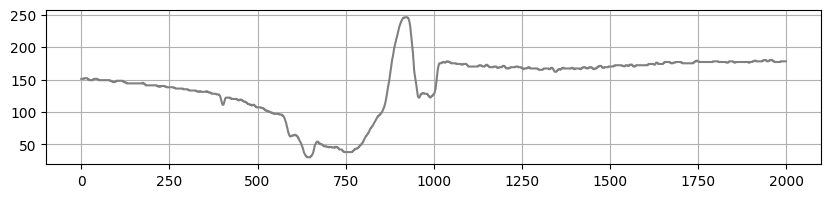

In [11]:
import numpy as np
import matplotlib.pyplot as plt

pixel_values = match_and_draw_normal_and_analyze(image_path, pas_reel_mm, reference_object_mm, False)

plt.figure(figsize=(10, 2))
plt.plot(pixel_values, color='gray')

plt.grid(True)
plt.show()

In [9]:
#methode ombre shadow removal modele de machine learning

In [10]:
match_and_draw_normal_and_analyze(image_path, pas_reel_mm, reference_object_mm, False)


array([151, 151, 151, ..., 178, 178, 178], dtype=uint8)